In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys; sys.path.append('../src')
from anndata_utils import plot_boxplots_by_group, plot_histograms_by_group


In [2]:
moa_dict = {
    'TC-S-7004': 'JAK/STAT inhibitor',        # JAK1 inhibitor (inhibits cytokine signaling)
    'BrefeldinA': 'Secretion inhibitor',      # ER-to-Golgi transport blocker (disrupts protein trafficking)
    'berberine chloride': 'Metabolic disruptor', # AMPK activator / Complex I inhibitor (affects metabolism and mitochondria)
    'CA-074-ME': 'Lysosome inhibitor',        # Cathepsin B inhibitor (blocks lysosomal protease)
    'Latrunculin A': 'Cytoskeleton disruptor',# Actin polymerization inhibitor (binds G-actin)
    'tetrandrine': 'Calcium modulator',       # Calcium channel blocker (affects Ca²⁺ signaling, autophagy)
    'DMSO': 'Vehicle control',                # Solvent control (minimal biological activity)
    '(S)-(+)-Camptothecin': 'DNA damage agent', # Topoisomerase I inhibitor (induces DNA strand breaks)
    'Nocodazole': 'Cytoskeleton disruptor',   # Microtubule polymerization inhibitor (binds β-tubulin)
    'Torin2': 'mTOR inhibitor',               # Blocks mTORC1/2 (affects growth, autophagy)
    'Calcimycin': 'Calcium ionophore',        # Increases intracellular Ca²⁺ (disrupts ion homeostasis)
    'Emetine dihydrochloride hydrate': 'Translation inhibitor', # Ribosomal translocation blocker (halts protein synthesis)
    'Rotenone': 'Mitochondrial inhibitor'     # Complex I inhibitor (blocks oxidative phosphorylation)
}


In [3]:
metadata = pd.read_csv('../data/ginkgo-datapoints_gdpx3_data-package/Ginkgo Datapoints_GDPx3_metadata.csv')
metadata['moa'] = metadata['compound'].map(moa_dict)
metadata.head(1)
metadata.shape

metadata['cell_line'].value_counts()
metadata['compound'].value_counts()

sample_id  container_id  column_id  row_id  is_edge   compound  \
0  105514688       1688388         22       4    False  TC-S-7004   

   compound_concentration compound_concentration_unit cell_line  timepoint  \
0                  1000.0                          nM      A549         24   

             condition  percent_volume_dmso sample_type is_neg_control  \
0  A549-TC-S-7004-1000                0.125     library            NaN   

  is_pos_control  seeded_cell_count                 moa  
0            NaN               1500  JAK/STAT inhibitor

(2528, 17)

cell_line
A549                                632
Human Dermal Fibroblast             632
Human aortic smooth muscle cells    632
human aortic endothelial cell       632
Name: count, dtype: int64

compound
DMSO                               480
BrefeldinA                         384
berberine chloride                 192
CA-074-ME                          192
Latrunculin A                      192
tetrandrine                        192
TC-S-7004                          128
(S)-(+)-Camptothecin               128
Nocodazole                         128
Torin2                             128
Calcimycin                         128
Emetine dihydrochloride hydrate    128
Rotenone                           128
Name: count, dtype: int64

In [4]:
median_features = pd.read_csv('../data/median_features.csv')
median_features.drop('container_id', axis=1, inplace=True)
median_features.head(1)
median_features.shape  # 49 samples less—probably dropped ones.

sample_id  Cytoplasm_AreaShape_Area  Cytoplasm_AreaShape_BoundingBoxArea  \
0  105526080                   26852.0                              72936.0   

   Cytoplasm_AreaShape_Compactness  Cytoplasm_AreaShape_ConvexArea  \
0                        11.655048                         39647.5   

   Cytoplasm_AreaShape_Eccentricity  Cytoplasm_AreaShape_EquivalentDiameter  \
0                          0.888662                              184.901891   

   Cytoplasm_AreaShape_EulerNumber  Cytoplasm_AreaShape_Extent  \
0                              0.0                    0.357731   

   Cytoplasm_AreaShape_FormFactor  ...  Nuclei_Texture_Variance_Red_10_02_256  \
0                          0.0858  ...                               0.478999   

   Nuclei_Texture_Variance_Red_10_03_256  \
0                               0.511588   

   Nuclei_Texture_Variance_Red_3_00_256  Nuclei_Texture_Variance_Red_3_01_256  \
0                              0.449264                              0.455722   

   Nuclei_Texture_Variance_Red_3_02_256  Nuclei_Texture_Variance_Red_3_03_256  \
0                              0.444072                              0.449859   

   Nuclei_Texture_Variance_Red_5_00_256  Nuclei_Texture_Variance_Red_5_01_256  \
0                              0.452227                              0.458858   

   Nuclei_Texture_Variance_Red_5_02_256  Nuclei_Texture_Variance_Red_5_03_256  
0                               0.45455                              0.465233  

[1 rows x 2770 columns]

(2479, 2770)

In [5]:
import anndata as ad

def make_anndata(X, obs):
    X = X.copy()
    obs = obs.copy()
    shared_index = X.index.intersection(obs.index)
    X = X.reindex(shared_index)
    obs = obs.reindex(shared_index)
    return ad.AnnData(X=X, obs=obs)

adata = make_anndata(median_features.set_index('sample_id'), obs=metadata.set_index('sample_id'))
adata

/Users/aru/Development/GDPx3/.venv/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2479 × 2769
    obs: 'container_id', 'column_id', 'row_id', 'is_edge', 'compound', 'compound_concentration', 'compound_concentration_unit', 'cell_line', 'timepoint', 'condition', 'percent_volume_dmso', 'sample_type', 'is_neg_control', 'is_pos_control', 'seeded_cell_count', 'moa'

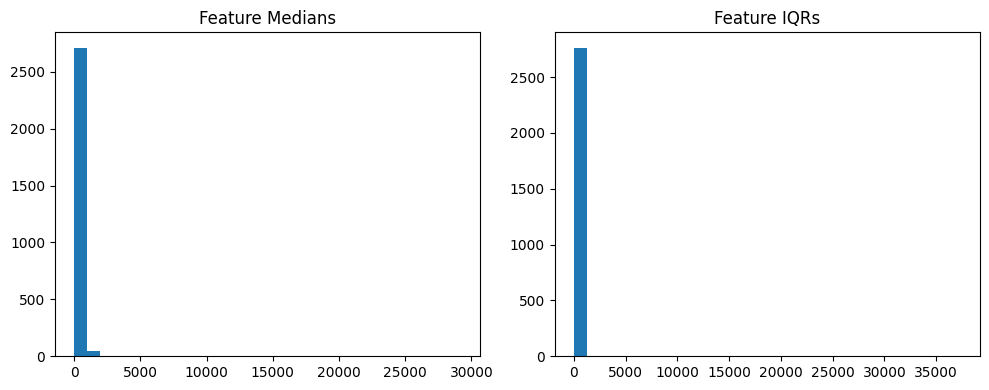

In [6]:
def check_scaling(adata, features=None, sample_size=500):
    """
    Check whether features appear scaled (zero median, ~unit IQR).
    """
    if features is None:
        features = adata.var_names

    X = adata[:, features].X
    medians = np.median(X, axis=0)
    iqrs = np.percentile(X, 75, axis=0) - np.percentile(X, 25, axis=0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(medians, bins=30)
    ax[0].set_title("Feature Medians")
    ax[1].hist(iqrs, bins=30)
    ax[1].set_title("Feature IQRs")
    plt.tight_layout()
    plt.show()

valid_prefixes = ('Cells_', 'Cytoplasm_', 'Nuclei_')
feature_columns = [f for f in adata.var_names if f.startswith(valid_prefixes)]
adata_f = adata[:, feature_columns]
check_scaling(adata_f)  # Not scaled

In [24]:
from sklearn.preprocessing import RobustScaler

def scale_per_group(
    adata,
    groupby_keys=['plate', 'percent_volume_dmso'],
    control_label='DMSO',
    source_layer=None,
    target_layer='scaled',
    strict=False
):
    """
    Scale features using RobustScaler fit on controls per group.
    
    Parameters:
        adata : AnnData
        groupby_keys : list of str
            Columns in adata.obs to group by.
        control_label : str
            Label in 'compound' column to use as control.
        source_layer : str or None
            Source layer to scale. If None, uses adata.X.
        target_layer : str
            Layer to write scaled data into.
        strict : bool
            If True, raise error on missing controls; else skip group.
    """
    X = adata.X if source_layer is None else adata.layers[source_layer]
    X = X.copy()
    obs = adata.obs.copy()

    scaled = np.full(X.shape, np.nan, dtype=np.float32)

    group_labels = obs[groupby_keys].astype(str).agg('|'.join, axis=1)

    for group in group_labels.unique():
        group_mask = group_labels == group
        control_mask = group_mask & (obs['compound'] == control_label)

        if np.sum(control_mask) < 2:
            if strict:
                raise ValueError(f"Insufficient controls in group: {group}")
            continue

        scaler = RobustScaler().fit(X[control_mask])
        scaled[group_mask] = scaler.transform(X[group_mask])

    adata.layers[target_layer] = scaled
    return adata

adata = scale_per_group(adata, groupby_keys=['container_id', 'percent_volume_dmso'])


In [8]:
from pycytominer import feature_select
import pandas as pd

def apply_feature_selection(
    adata,
    layer='scaled',
    operations=['variance_threshold', 'correlation_threshold'],
    copy=True
):
    """
    Applies pycytominer feature_select to scaled data and updates adata with only selected features.

    Parameters
    ----------
    adata : AnnData
        The AnnData object to filter.
    layer : str
        Which layer to use for feature selection (e.g., 'scaled').
    operations : list of str
        Feature selection operations to apply.
    copy : bool
        If True, returns a new AnnData object. If False, modifies in place.

    Returns
    -------
    AnnData
        The filtered AnnData object.
    """
    if copy:
        adata = adata.copy()

    print(f"🔍 Applying feature selection on layer '{layer}' using operations: {operations}")

    X = adata.to_df(layer=layer)
    feature_columns = X.columns.tolist()
    print(f"📊 Starting with {len(feature_columns):,} features")

    X_selected = feature_select(
        X,
        features=feature_columns,
        operation=operations
    )

    print(f"✅ Retained {X_selected.shape[1]:,} features after selection ({len(feature_columns) - X_selected.shape[1]:,} removed)")

    adata = adata[:, X_selected.columns]

    return adata

apply_feature_selection(adata=adata, copy=False)

# Write selected features to file
with open('../data/features_selected.txt', 'w+') as f:
    for line in adata.var_names:
        _ = f.write(line + '\n')

🔍 Applying feature selection on layer 'scaled' using operations: ['variance_threshold', 'correlation_threshold']
📊 Starting with 2,769 features
✅ Retained 766 features after selection (2,003 removed)


View of AnnData object with n_obs × n_vars = 2479 × 766
    obs: 'container_id', 'column_id', 'row_id', 'is_edge', 'compound', 'compound_concentration', 'compound_concentration_unit', 'cell_line', 'timepoint', 'condition', 'percent_volume_dmso', 'sample_type', 'is_neg_control', 'is_pos_control', 'seeded_cell_count', 'moa'
    layers: 'scaled'

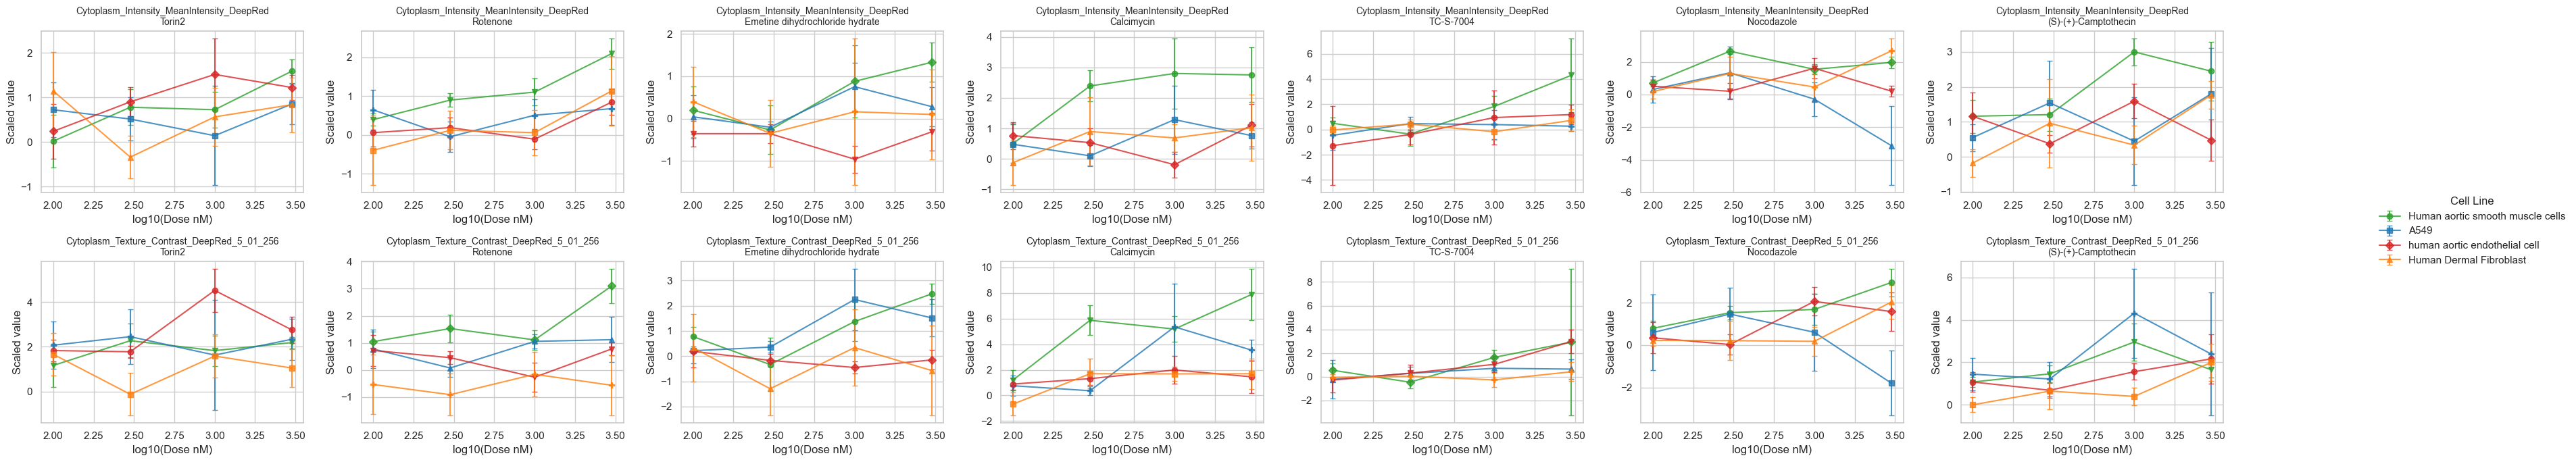

In [18]:
def plot_dose_response(
    adata,
    compounds,
    features,
    cell_lines=None,
    layer='scaled',
    dose_key='compound_concentration',
    col_wrap=3,
    height=3.5,
    palette='tab10'
):
    """
    Plot dose-response curves with median ± IQR for multiple features, compounds, and cell lines using seaborn-style subplots.
    """
    sns.set_theme(style="whitegrid")

    if cell_lines is None:
        cell_lines = sorted(adata.obs['cell_line'].unique())

    n_panels = len(compounds) * len(features)
    n_cols = col_wrap
    n_rows = math.ceil(n_panels / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * height * 1.6, n_rows * height), squeeze=False)
    axes = axes.flatten()

    # Color map by cell line
    unique_lines = sorted(cell_lines)
    color_map = dict(zip(unique_lines, sns.color_palette(palette, n_colors=len(unique_lines))))
    marker_cycle = itertools.cycle(['o', 's', 'D', '^', 'v', 'P'])

    plot_idx = 0
    for feature in features:
        for compound in compounds:
            if plot_idx >= len(axes):
                break

            ax = axes[plot_idx]
            for cell_line in cell_lines:
                mask = (
                    (adata.obs['compound'] == compound) &
                    (adata.obs['cell_line'] == cell_line)
                )
                ad = adata[mask, :]
                if ad.n_obs == 0 or feature not in ad.var_names:
                    continue

                X = ad.layers[layer]
                values = X[:, ad.var_names.get_loc(feature)]
                df = pd.DataFrame({
                    'dose': ad.obs[dose_key].astype(float).values,
                    'feature': values
                })

                grouped = df.groupby('dose')['feature']
                summary = pd.DataFrame({
                    'dose': grouped.mean().index,
                    'median': grouped.median().values,
                    'q25': grouped.quantile(0.25).values,
                    'q75': grouped.quantile(0.75).values
                })
                summary['iqr'] = summary['q75'] - summary['q25']
                summary['log10_dose'] = np.log10(summary['dose'])

                label = f"{cell_line}"
                color = color_map[cell_line]
                marker = next(marker_cycle)

                ax.errorbar(
                    summary['log10_dose'],
                    summary['median'],
                    yerr=summary['iqr'] / 2,
                    fmt=f'{marker}-',
                    capsize=3,
                    label=label,
                    color=color,
                    alpha=0.8
                )

            ax.set_title(f"{feature}\n{compound}", fontsize=10)
            ax.set_xlabel("log10(Dose nM)")
            ax.set_ylabel("Scaled value")
            ax.grid(True)

            plot_idx += 1

    # Remove empty axes
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    # Shared legend (cell line color-coded)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title='Cell Line',
        loc='center left',
        bbox_to_anchor=(0.9, 0.5),
        borderaxespad=0.5,
        frameon=False
    )
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on right for legend
    plt.show()

compound_list = ['Torin2', 'Rotenone', 'Emetine dihydrochloride hydrate', 'Calcimycin', 'TC-S-7004', 'Nocodazole', '(S)-(+)-Camptothecin']
plot_dose_response(
    adata=adata,
    # compounds=['Rotenone'],
    compounds=compound_list,
    features=['Cytoplasm_Intensity_MeanIntensity_DeepRed', 'Cytoplasm_Texture_Contrast_DeepRed_5_01_256'],
    cell_lines=['Human aortic smooth muscle cells', 'A549', 'human aortic endothelial cell', 'Human Dermal Fibroblast'],
    col_wrap=7
)


In [19]:
mitochondria_features = [
    # --- Intensity ---
    "Cytoplasm_Intensity_IntegratedIntensity_DeepRed",     # Total mitochondrial signal; reflects mass/content
    "Cytoplasm_Intensity_MeanIntensity_DeepRed",           # Avg pixel intensity; reflects density or membrane potential
    "Cytoplasm_Intensity_StdIntensity_DeepRed",            # Variation in intensity; indicates heterogeneity or damage
    "Cytoplasm_Intensity_MaxIntensity_DeepRed",            # Brightest pixel; may indicate foci or hyperpolarization
    "Cytoplasm_Intensity_MassDisplacement_DeepRed",        # Offset between cytoplasm and intensity center; spatial distribution

    # --- Radial Distribution ---
    "Cytoplasm_RadialDistribution_FracAtD_DeepRed_1of4",   # Mito signal near nucleus
    "Cytoplasm_RadialDistribution_FracAtD_DeepRed_2of4",   # Signal in inner-mid zone
    "Cytoplasm_RadialDistribution_FracAtD_DeepRed_3of4",   # Signal in outer-mid zone
    "Cytoplasm_RadialDistribution_FracAtD_DeepRed_4of4",   # Mito signal near periphery

    "Cytoplasm_RadialDistribution_MeanFrac_DeepRed_1of4",  # Mean signal in inner 1/4
    "Cytoplasm_RadialDistribution_MeanFrac_DeepRed_2of4",  # Mid-inner
    "Cytoplasm_RadialDistribution_MeanFrac_DeepRed_3of4",  # Mid-outer
    "Cytoplasm_RadialDistribution_MeanFrac_DeepRed_4of4",  # Mean signal near membrane

    "Cytoplasm_RadialDistribution_RadialCV_DeepRed_1of4",  # CV of intensity near nucleus
    "Cytoplasm_RadialDistribution_RadialCV_DeepRed_2of4",  # Inner-mid variation
    "Cytoplasm_RadialDistribution_RadialCV_DeepRed_3of4",  # Outer-mid variation
    "Cytoplasm_RadialDistribution_RadialCV_DeepRed_4of4",  # Variation at periphery

    # --- Texture ---
    "Cytoplasm_Texture_Entropy_DeepRed_3_01_256",          # Texture entropy (fine scale); fragmentation
    "Cytoplasm_Texture_Entropy_DeepRed_5_01_256",          # Entropy at medium scale
    "Cytoplasm_Texture_Entropy_DeepRed_10_01_256",         # Entropy at coarse scale

    "Cytoplasm_Texture_Correlation_DeepRed_3_01_256",      # Pixel correlation (fine scale); fused networks
    "Cytoplasm_Texture_Correlation_DeepRed_5_01_256",      # Medium-range correlation
    "Cytoplasm_Texture_Correlation_DeepRed_10_01_256",     # Long-range correlation

    "Cytoplasm_Texture_AngularSecondMoment_DeepRed_3_01_256", # Uniformity; smooth textures
    "Cytoplasm_Texture_AngularSecondMoment_DeepRed_5_01_256", # Uniformity (coarser scale)

    "Cytoplasm_Texture_Contrast_DeepRed_3_01_256",         # Local contrast; fragmentation, small structures
    "Cytoplasm_Texture_Contrast_DeepRed_5_01_256",         # Medium contrast
    "Cytoplasm_Texture_Contrast_DeepRed_10_01_256",        # Large-scale contrast

    # --- Granularity ---
    "Cytoplasm_Granularity_1_DeepRed",                     # Small puncta
    "Cytoplasm_Granularity_2_DeepRed",                     # Slightly larger dots
    "Cytoplasm_Granularity_3_DeepRed",                     # Small filamentous shapes
    "Cytoplasm_Granularity_5_DeepRed",                     # Medium granularity (swollen/fused)
    "Cytoplasm_Granularity_10_DeepRed",                    # Large granules or fused networks
    "Cytoplasm_Granularity_15_DeepRed",                    # Coarse/aggregated structures

    # --- Channel Correlation ---
    "Cytoplasm_Correlation_Correlation_DeepRed_Green",     # Mito-ER correlation (if Green = ER)
    "Cytoplasm_Correlation_Correlation_DeepRed_Red",       # Mito-Golgi/membrane correlation (if Red = Golgi)
]


✅ Found 36 mitochondrial features after selection.


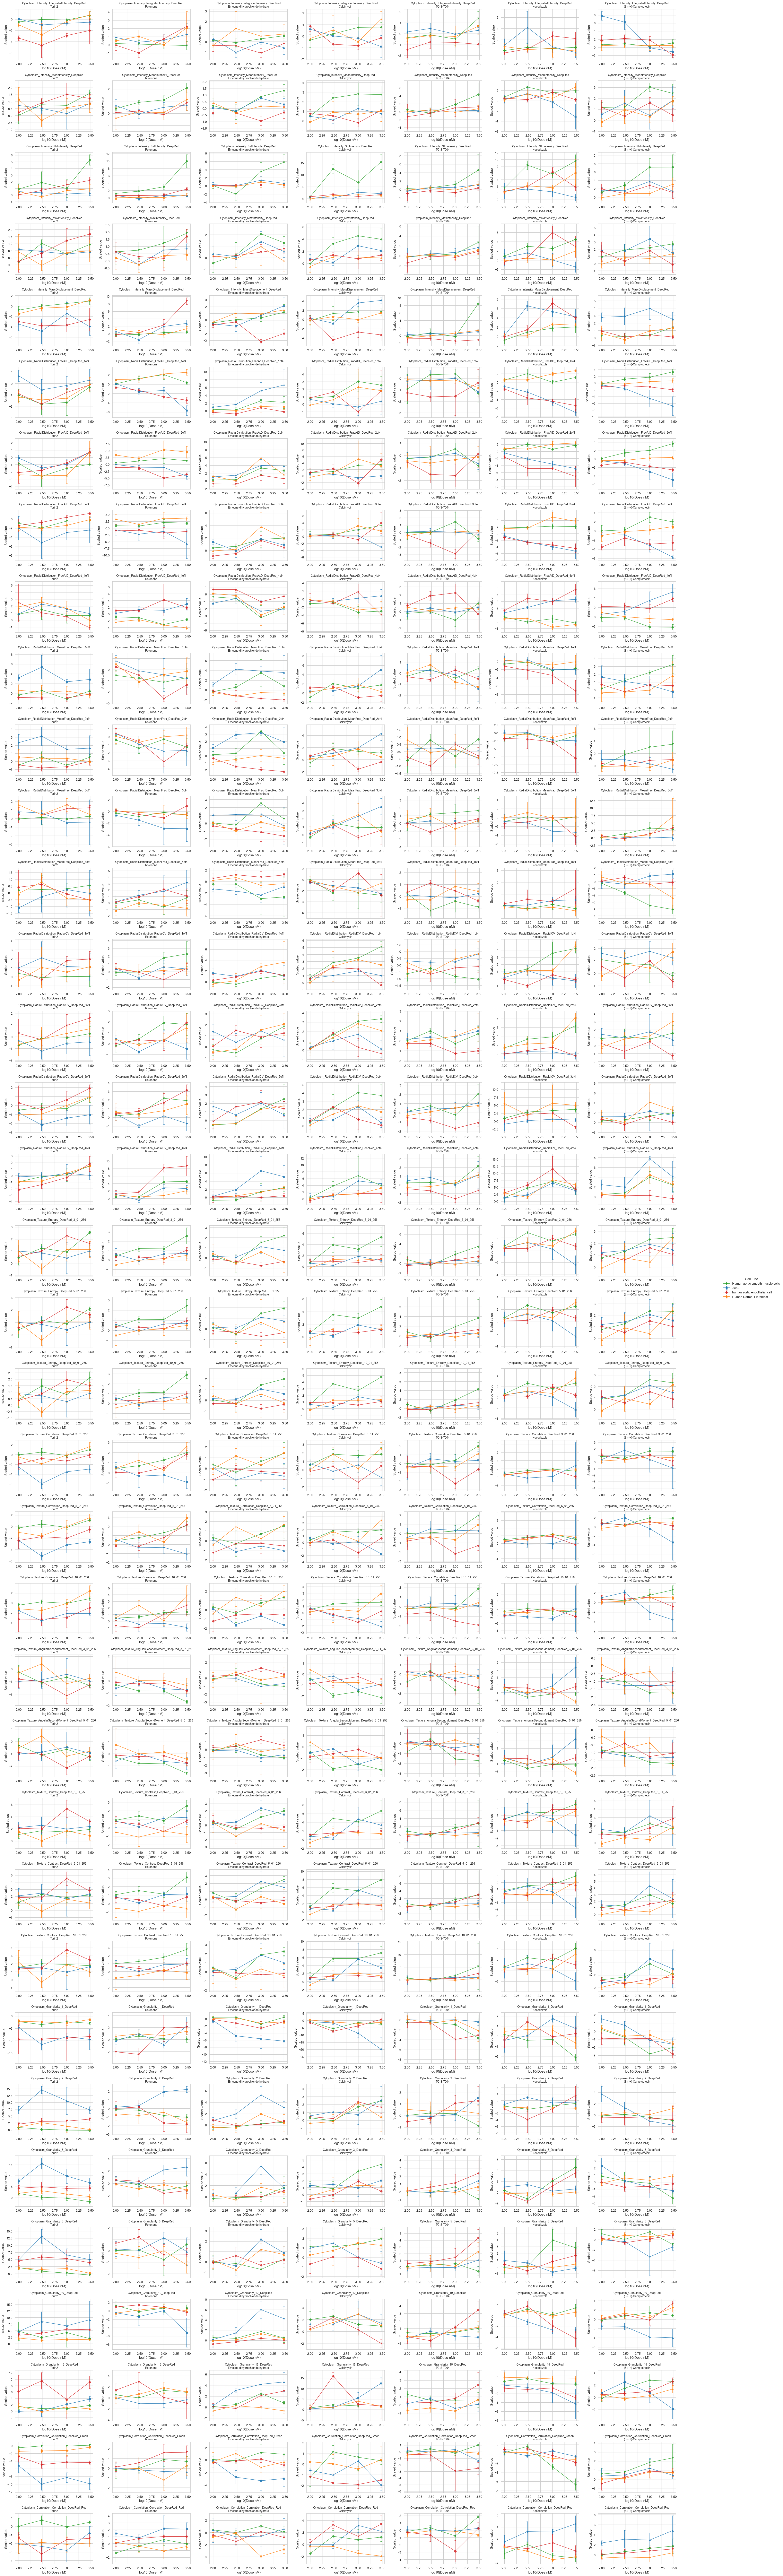

In [22]:
# Filtered mitochondrial feature list
mitochondria_features_filtered = [
    f for f in mitochondria_features if f in adata.var_names
]

print(f"✅ Found {len(mitochondria_features_filtered)} mitochondrial features after selection.")

adata_mito = adata[:, mitochondria_features_filtered]

plot_dose_response(
    adata=adata_mito,
    compounds=compound_list,
    # compounds=['berberine chloride'],
    features=adata_mito.var_names,
    cell_lines=['Human aortic smooth muscle cells', 'A549', 'human aortic endothelial cell', 'Human Dermal Fibroblast'],
    col_wrap=7
)


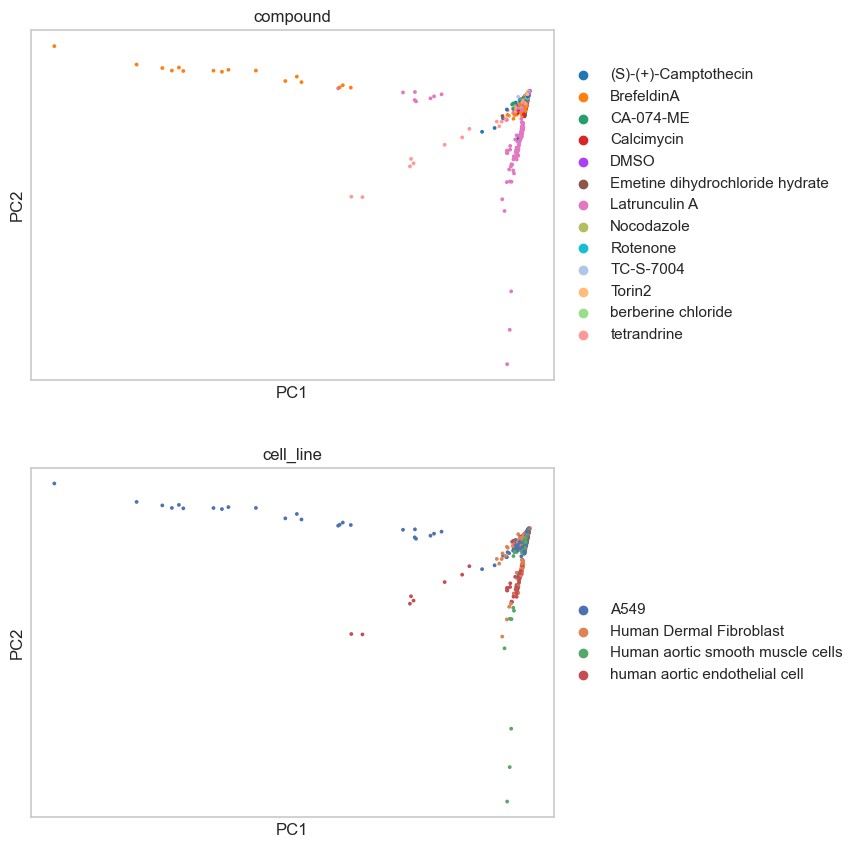

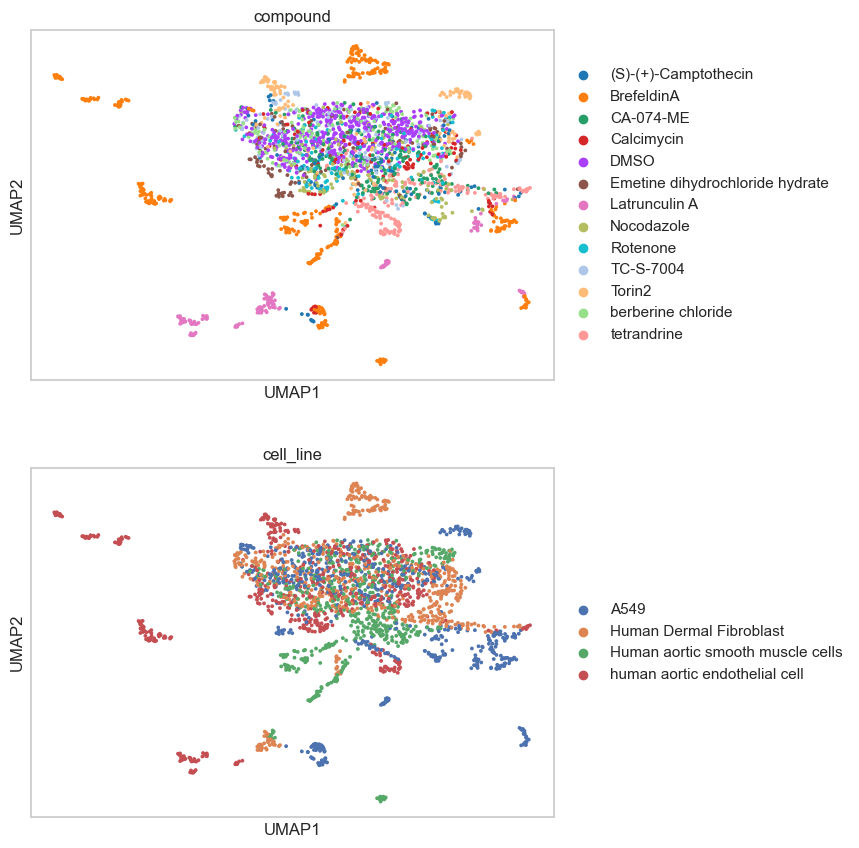

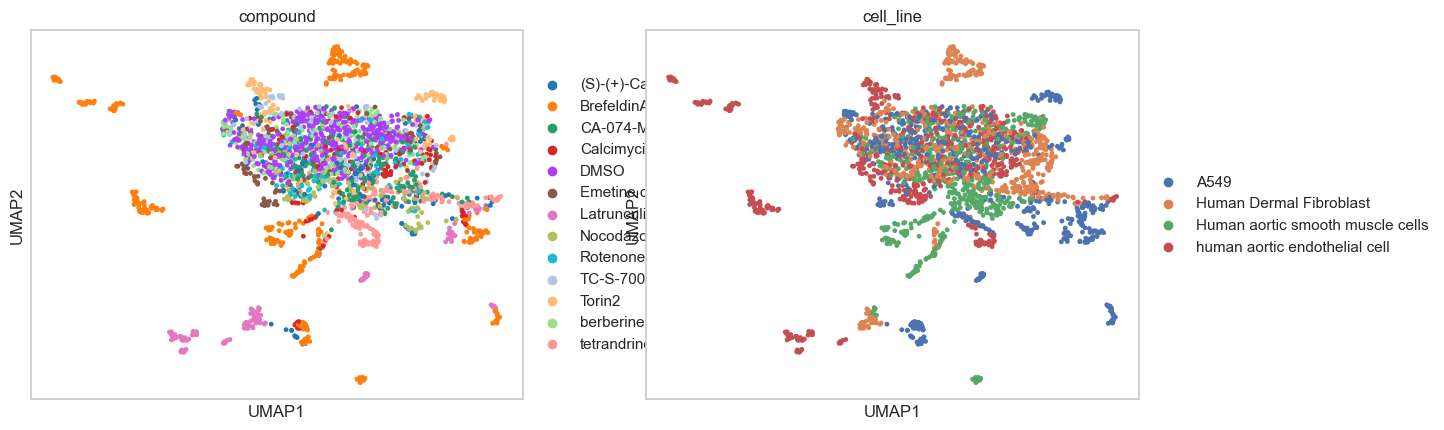

In [23]:
import scanpy as sc

# adata = adata_mito[adata_mito.obs['cell_line'] == 'A549', :].copy()
sc.pp.pca(adata, layer='scaled')
sc.pl.pca(
    adata,
    color=['compound', 'cell_line'],
    components=['1,2'],
    ncols=1,
    size=30
)

# Use PCA coordinates to compute neighbors
sc.pp.neighbors(adata, use_rep='X_pca')

# Compute UMAP
sc.tl.umap(adata)

# Plot
sc.pl.umap(
    adata,
    color=['compound', 'cell_line'],
    size=30,
    ncols=1
)

sc.pl.umap(adata, color=['compound', 'cell_line'])


In [15]:
adata.obs['compound'].unique().tolist()



['DMSO',
 'BrefeldinA',
 'tetrandrine',
 'CA-074-ME',
 'Torin2',
 '(S)-(+)-Camptothecin',
 'berberine chloride',
 'Calcimycin',
 'Rotenone',
 'Nocodazole',
 'Latrunculin A',
 'TC-S-7004',
 'Emetine dihydrochloride hydrate']

In [ ]:
adata_hasmc = adata[adata.obs['cell_line'] == 'Human aortic smooth muscle cells', :]
adata_hasmc

adata_hasmc.obs['timepoint'].value_counts()
adata_hasmc.obs['compound'].value_counts()
adata_hasmc.obs['compound_concentration'].value_counts()

In [ ]:
mt_cpds = ['DMSO', 'berberine chloride', 'Rotenone']
mt_features = [f for f in adata.var_names if 'DeepRed' in f and 'Cytoplasm' in f]

print(f'Number of mitochondrial features: {len(mt_features)}')

In [ ]:
from sklearn.linear_model import LinearRegression

# example for one feature
feature = 'Cytoplasm_Intensity_MeanIntensity_DeepRed'
df = adata_hasmc[adata_hasmc.obs['compound'] == 'Rotenone', :].to_df()
y = df[feature].values
X = adata_hasmc.obs.loc[df.index, 'compound_concentration'].values.reshape(-1, 1)
model = LinearRegression().fit(np.log10(X), y)

# 2. Subset HASMC + Rotenone samples
adata_rotenone = adata_hasmc[adata_hasmc.obs['compound'] == 'Rotenone', :]

# 3. Pull out dose and feature
df = pd.DataFrame({
    'dose_nM': adata_rotenone.obs['compound_concentration'].astype(float),
    'feature_value': adata_rotenone[:, feature].X.flatten()
})

# 4. Take log10 of dose for plotting (log-scale)
df['log10_dose'] = np.log10(df['dose_nM'])

# 5. Plot with jitter and trend line
plt.figure(figsize=(6, 4))
sns.stripplot(data=df, x='log10_dose', y='feature_value', jitter=True, alpha=0.6)
sns.lineplot(data=df.groupby('log10_dose').median(numeric_only=True).reset_index(),
             x='log10_dose', y='feature_value', marker='o', label='Median')
plt.xlabel('log10(Rotenone concentration in nM)')
plt.ylabel(feature)
plt.title(f'{feature} vs Rotenone Dose')
plt.tight_layout()
plt.show()



In [21]:
import sys
sys.path.append('../src')
from anndata_utils import plot_boxplots_by_group, plot_histograms_by_group


In [ ]:
plot_boxplots_by_group(
    adata=adata_hasmc, 
    var_names=['Cytoplasm_Intensity_MeanIntensity_DeepRed', 'Cytoplasm_Intensity_MaxIntensity_DeepRed'],
    obs_names='moa'
)